In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

In [67]:
df = pd.read_csv("dataset/online_retail_II.csv")

df = df.dropna(subset=["Price", "Quantity"])
df = df[(df["Price"] > 0) & (df["Quantity"] > 0)]

q_low, q_high = 0.01, 0.99
price_low, price_high = df["Price"].quantile(q_low), df["Price"].quantile(q_high)
quantity_low, quantity_high = df["Quantity"].quantile(q_low), df["Quantity"].quantile(q_high)
df = df[(df["Price"] >= price_low) & (df["Price"] <= price_high) &
            (df["Quantity"] >= quantity_low) & (df["Quantity"] <= quantity_high)]

features = df[["Price", "Quantity"]].values

min_vals = features.min(axis=0)
max_vals = features.max(axis=0)
norm_features = (features - min_vals) / (max_vals - min_vals)

In [68]:
class SOM:
    def __init__(
        self,
        m: int,
        n: int,
        dim: int,
        learning_rate: float = 0.5,
        sigma: float | None = None,
        num_iterations: int = 1000,
    ) -> None:
        self.m = m
        self.n = n
        self.dim = dim
        self.learning_rate = learning_rate
        self.initial_lr = learning_rate
        self.num_iterations = num_iterations
        if sigma is None:
            self.sigma = max(m, n) / 2.0
        else:
            self.sigma = sigma
        self.initial_sigma = self.sigma

        self.weights = np.random.rand(m, n, dim)

    def get_bmu(self, x):
        diff = self.weights - x
        dist = np.linalg.norm(diff, axis=2)
        bmu_index = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
        return bmu_index

    def decay_radius(self, iteration):
        time_constant = self.num_iterations / np.log(self.initial_sigma)
        return self.initial_sigma * np.exp(-iteration / time_constant)

    def decay_learning_rate(self, iteration):
        return self.initial_lr * np.exp(-iteration / self.num_iterations)

    def neighborhood_func(self, bmu_idx, iteration):
        radius = self.decay_radius(iteration)
        x_coords, y_coords = np.meshgrid(np.arange(self.m), np.arange(self.n), indexing="ij")
        distance_sq = (x_coords - bmu_idx[0])**2 + (y_coords - bmu_idx[1])**2
        neighborhood = np.exp(-distance_sq / (2 * (radius ** 2)))
        return neighborhood

    def train(self, df):
        for iteration in range(self.num_iterations):
            idx = np.random.randint(0, df.shape[0])
            x = df[idx]
            bmu_idx = self.get_bmu(x)
            neighborhood = self.neighborhood_func(bmu_idx, iteration)
            current_lr = self.decay_learning_rate(iteration)

            for i in range(self.m):
                for j in range(self.n):
                    influence = neighborhood[i, j]
                    self.weights[i, j, :] += current_lr * influence * (x - self.weights[i, j, :])

        return self.weights

In [69]:
grid_rows = 10
grid_cols = 10
input_dim = norm_features.shape[1]
learning_rate = 0.5
sigma = max(grid_rows, grid_cols) / 2.0
num_iterations = 1000

som = SOM(
    m=grid_rows,
    n=grid_cols,
    dim=input_dim,
    learning_rate=learning_rate,
    sigma=sigma,
    num_iterations=num_iterations
)
weights = som.train(norm_features)

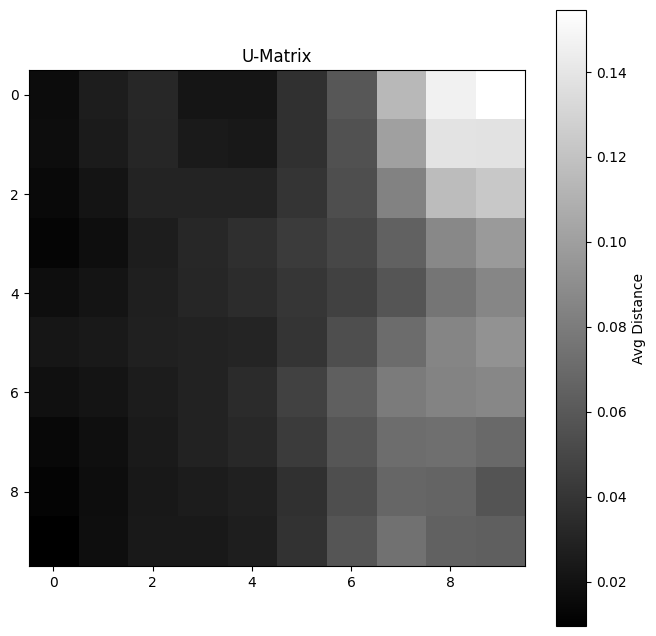

In [70]:
u_matrix = np.zeros((grid_rows, grid_cols))

for i in range(grid_rows):
    for j in range(grid_cols):
        neighbors = []

        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                ni = i + di
                nj = j + dj
                if 0 <= ni < grid_rows and 0 <= nj < grid_cols:
                    neighbors.append(som.weights[ni, nj])
        if neighbors:
            distances = [np.linalg.norm(som.weights[i, j] - neighbor) for neighbor in neighbors]
            u_matrix[i, j] = np.mean(distances)

plt.figure(figsize=(8, 8))
plt.imshow(u_matrix, cmap="gray")
plt.title("U-Matrix")
plt.colorbar(label="Avg Distance")
plt.show()

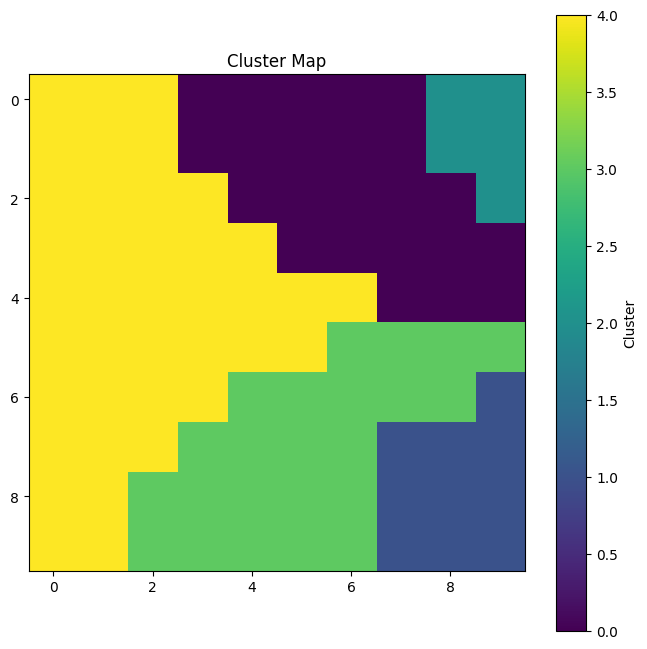

In [71]:
cluster_weights = som.weights.reshape(-1, input_dim)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(cluster_weights)

plt.figure(figsize=(8, 8))
plt.imshow(clusters.reshape(grid_rows, grid_cols), cmap="viridis")
plt.title("Cluster Map")
plt.colorbar(label="Cluster")
plt.show()

In [72]:
kmeans_data = KMeans(n_clusters=n_clusters, random_state=42)
labels_data = kmeans_data.fit_predict(norm_features)

print("KMeans Metrics")
print(f"Davies-Bouldin Index: {davies_bouldin_score(norm_features, labels_data):.3f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(norm_features, labels_data):.3f}")

KMeans Metrics
Davies-Bouldin Index: 0.697
Calinski-Harabasz Score: 1258161.867


In [75]:
som_labels = []
for x in norm_features:
    bmu = som.get_bmu(x)
    idx = bmu[0] * grid_cols + bmu[1]
    som_labels.append(clusters[idx])
som_labels = np.array(som_labels)

print("SOM Metrics")
print(f"Davies-Bouldin Index: {davies_bouldin_score(norm_features, som_labels):.3f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(norm_features, som_labels):.3f}")


SOM Metrics
Davies-Bouldin Index: 0.725
Calinski-Harabasz Score: 1140177.929


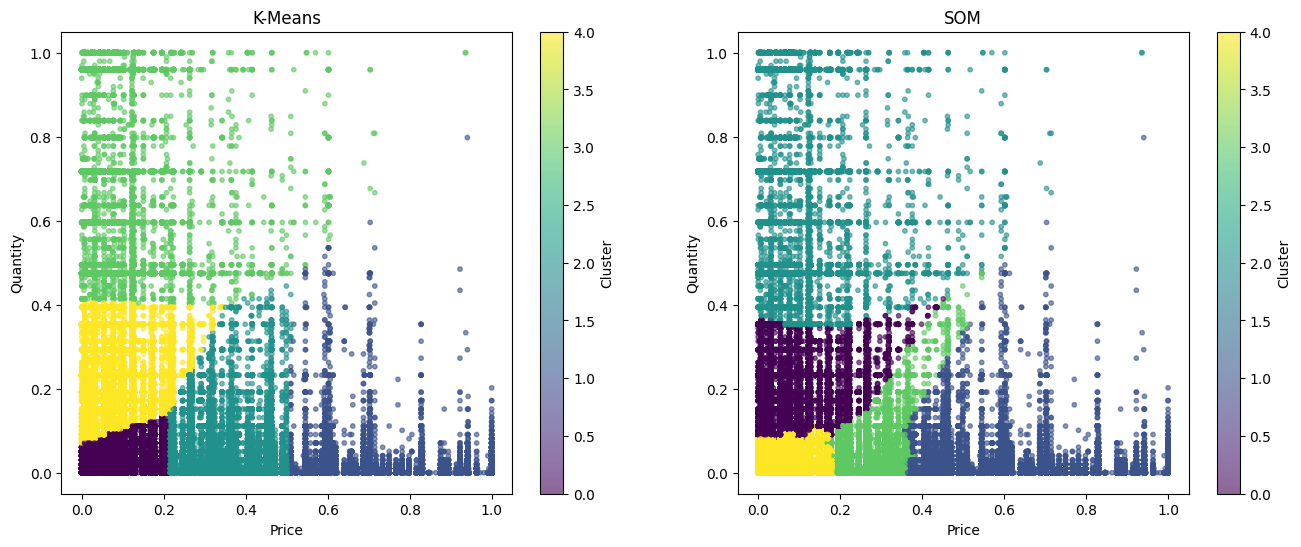

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

scatter = ax[0].scatter(norm_features[:, 0], norm_features[:, 1], c=labels_data, cmap="viridis", s=10, alpha=0.6)
ax[0].set_title("K-Means")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Quantity")
plt.colorbar(scatter, label="Cluster")

scatter = ax[1].scatter(norm_features[:, 0], norm_features[:, 1], c=som_labels, cmap="viridis", s=10, alpha=0.6)
ax[1].set_title("SOM")
ax[1].set_xlabel("Price")
ax[1].set_ylabel("Quantity")
plt.colorbar(scatter, label="Cluster")

plt.show()